# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value" ICML 2023 , using pyDVL.
https://proceedings.mlr.press/v202/kwon23e.html

The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms computes data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std, plot_best_worst, plot_best_worst_class_imbalance, compute_best_worst_scores, plot_methods_linreg
from pydvl.value.result import ValuationResult

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
import pandas as pd
from sklearn.datasets import load_iris

data = Dataset.from_sklearn(load_iris())

In [3]:

#model = KNeighborsClassifier(n_neighbors=5)
model = DecisionTreeClassifier(max_depth=5,)
#model = LogisticRegression()
utility = Utility(model, data, Scorer("balanced_accuracy", default=0.0))

# Base estimator

In [4]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF

In [5]:

scorer = Scorer("balanced_accuracy", default=0.0)

model = LogisticRegression()
dict_utilities = {}
utility = Utility(KNeighborsClassifier(n_neighbors=5), data, scorer)
dict_utilities["KNN"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=2,), data, scorer)
dict_utilities["DecisionTreeShallow"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=20,), data, scorer)
dict_utilities["DecisionTreeDeep"] = utility
utility = Utility(LogisticRegression(), data, scorer)
dict_utilities["LogisticRegression"] = utility
#utility = Utility(GaussianProcessClassifier(1.0 * RBF(1.0)), data, scorer)
#dict_utilities["GaussianProcess"] = utility
#utility = Utility(GaussianNB(), data, scorer)
#dict_utilities["GaussianNB"] = utility
#utility = Utility(MLPClassifier(), data, scorer)
#dict_utilities["MLPClassifier"] = utility
utility = Utility(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), data, scorer)
dict_utilities["RandomForest"] = utility
utility = Utility(AdaBoostClassifier(), data, scorer)
dict_utilities["AdaBoost"] = utility
#utility_lr = Utility(LogisticRegression(), data, scorer)
#dict_utilities["KNN"] = utility_knn
utility = Utility(LGBMClassifier(verbose= -1), data, scorer)
dict_utilities["LGBM"] = utility

dict_utilities.keys()

dict_keys(['KNN', 'DecisionTreeShallow', 'DecisionTreeDeep', 'LogisticRegression', 'RandomForest', 'AdaBoost', 'LGBM'])

In [6]:
def oob_func(utility, model_name):
    return(compute_data_oob(dict_utilities[model_name], n_est=30, max_samples=0.8, progress=False))
kwargs_list = [{"model_name":m} for m in dict_utilities.keys()]

In [7]:
area_under_curve_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
area_under_curve_worse = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))

In [10]:
def compute_random_baseline_best_worst_mean(n_iter, utility_eval, removal_percentages):
    random_vals = [ValuationResult.from_random(size=len(utility.data)) for _ in range(n_iter)]
    best_random_score = [compute_removal_score(u=utility,
                                            values=vals,
                                            percentages=removal_percentages,
                                            remove_best=True,) for vals in random_vals]
    df_random_best = pd.DataFrame(best_random_score)
    df_random_best = df_random_best.mean()

    worst_random_score = [compute_removal_score(u=utility_eval,
                                            values=vals,
                                            percentages=removal_percentages,
                                            remove_best=False,) for vals in random_vals]
    df_random_worst = pd.DataFrame(worst_random_score)
    df_random_worst = df_random_worst.mean()
    return(df_random_best, df_random_worst)

In [11]:
n_iter = 2
removal_percentages = np.arange(0, 0.99, 0.05)

area_under_curve_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
area_under_curve_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
diff_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
diff_random_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
single_best_gain_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
single_best_gain_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))

for k in kwargs_list:
    model_name = k["model_name"]
    utility_eval = dict_utilities[model_name]
    df_random_best, df_random_worst = compute_random_baseline_best_worst_mean(n_iter, utility_eval, removal_percentages)
    best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list,f_name="", return_values=True)
    best_scores_df.loc[:,"method_name"] = best_scores_df.loc[:,"method_name"].apply(lambda x: "_".join(x.split("_")[1:]))
    worst_scores_df.loc[:,"method_name"] = worst_scores_df.loc[:,"method_name"].apply(lambda x: "_".join(x.split("_")[1:]))
    df_mean_best = best_scores_df.groupby("method_name").mean()
    df_mean_worst = worst_scores_df.groupby("method_name").mean()

    area_under_curve_best.loc[:,model_name] = df_mean_best.sum(axis=1)/len(removal_percentages)
    area_under_curve_worst.loc[:,model_name] = df_mean_worst.sum(axis=1)/len(removal_percentages)

    best_compare_random = df_mean_best.apply(lambda row: np.array(row.values < df_random_best, dtype=int), axis=1)
    worst_compare_random = df_mean_worst.apply(lambda row: np.array(row.values > df_random_worst, dtype=int), axis=1)
    percent_above_random_best.loc[:,model_name] = best_compare_random.apply(lambda x: np.mean(x))
    percent_above_random_worst.loc[:,model_name] = worst_compare_random.apply(lambda x: np.mean(x))

    diff_random_best.loc[:,model_name] = df_mean_best.apply(lambda row: sum(np.array(row.values - df_random_best, dtype=float)), axis=1)
    diff_random_worst.loc[:,model_name] = df_mean_worst.apply(lambda row: sum(np.array(row.values - df_random_worst, dtype=float)), axis=1)

    single_best_gain_best.loc[:,model_name] = df_mean_best.apply(lambda row: min(np.array(row.values - df_random_best, dtype=float)), axis=1)
    single_best_gain_worst.loc[:,model_name] = df_mean_worst.apply(lambda row: max(np.array(row.values - df_random_worst, dtype=float)), axis=1)

    

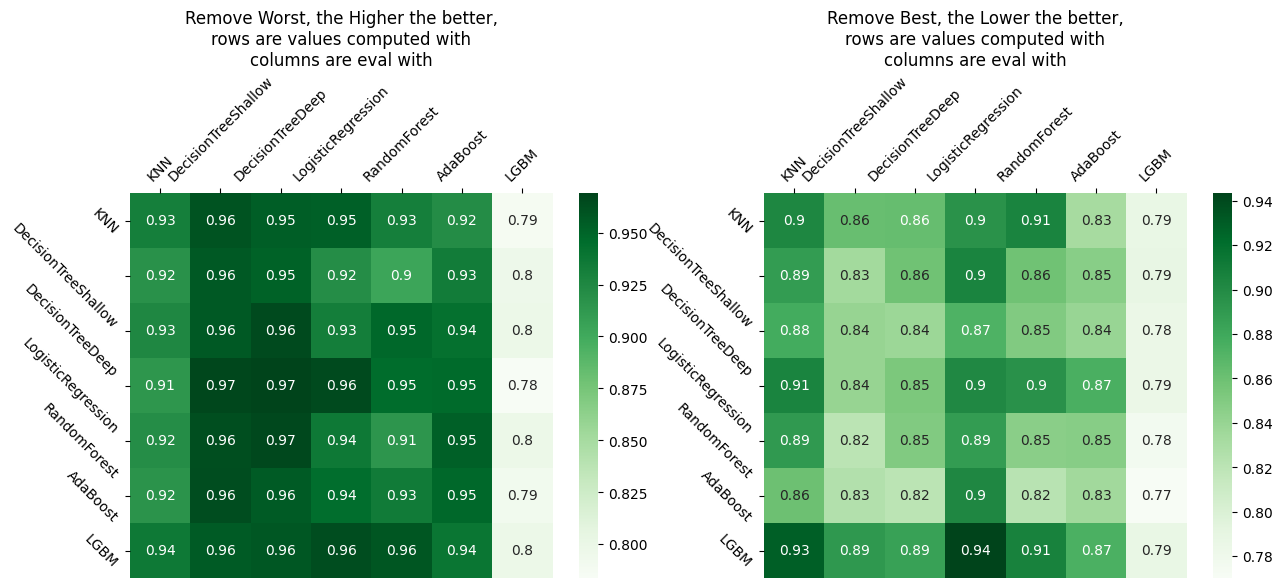

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)
sns.heatmap(area_under_curve_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap="Greens")
sns.heatmap(area_under_curve_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap="Greens")

ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best, the Lower the better,\nrows are values computed with\ncolumns are eval with")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)
ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst, the Higher the better,\nrows are values computed with\ncolumns are eval with")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
plt.show()

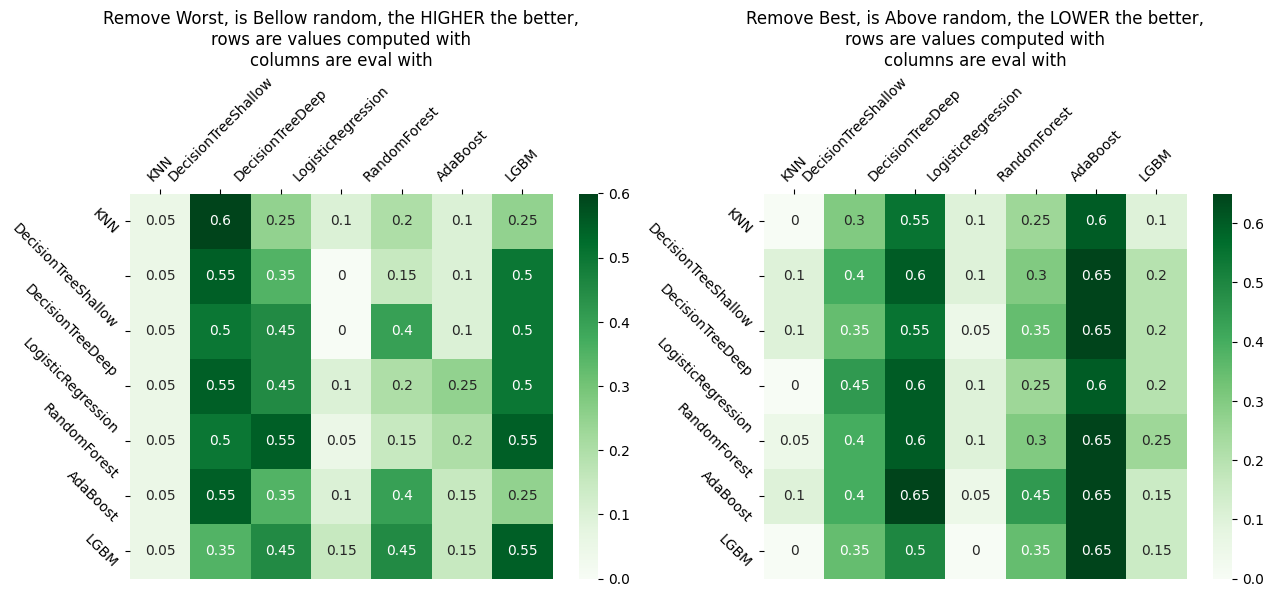

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)
sns.heatmap(percent_above_random_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap = "Greens")
sns.heatmap(percent_above_random_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap = "Greens")

ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best, is Above random, the LOWER the better,\nrows are values computed with\ncolumns are eval with")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)
ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst, is Bellow random, the HIGHER the better,\nrows are values computed with\ncolumns are eval with")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
plt.show()

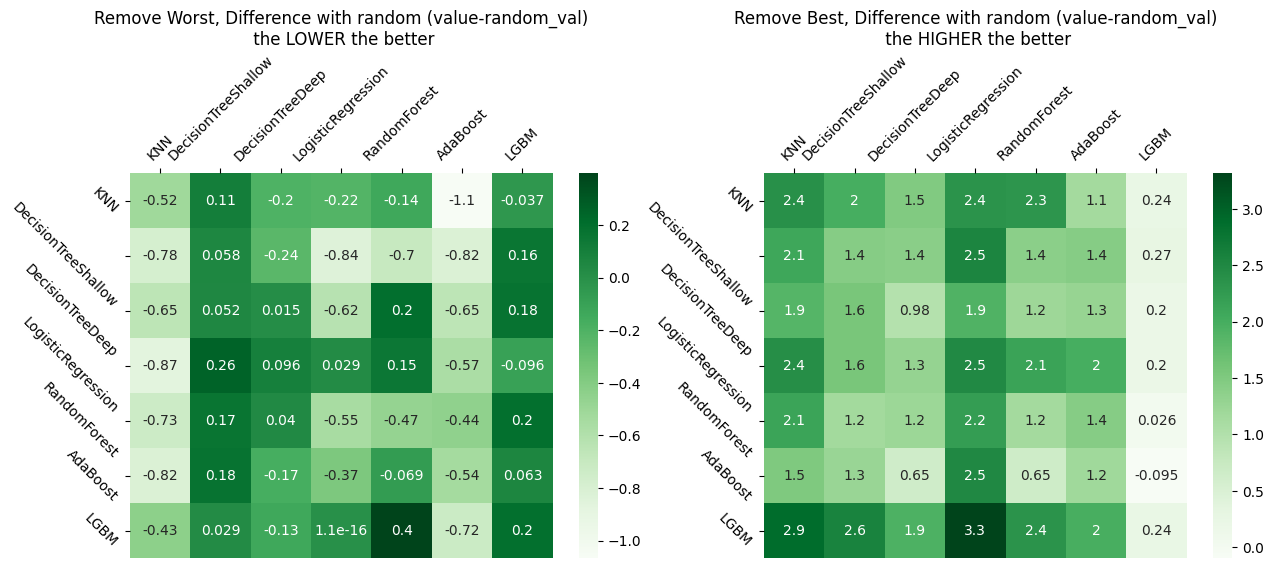

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)
sns.heatmap(diff_random_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap = 'Greens')
sns.heatmap(diff_random_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap = 'Greens')

ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best, Difference with random (value-random_val)\n the HIGHER the better")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)
ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst, Difference with random (value-random_val)\n the LOWER the better")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
plt.show()

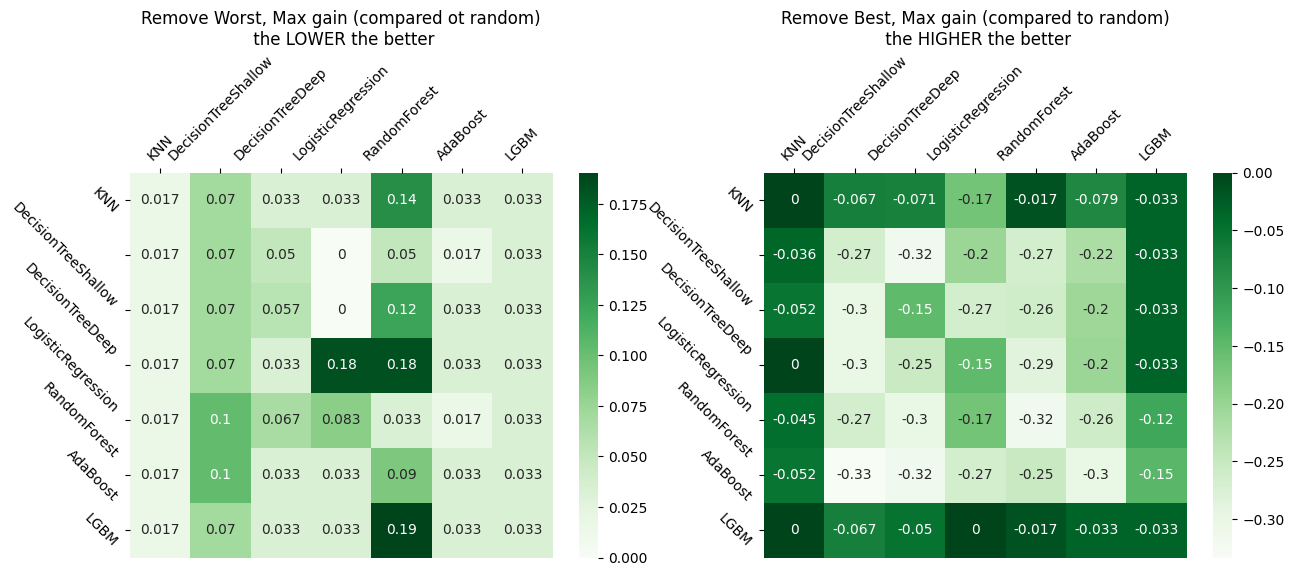

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)
sns.heatmap(single_best_gain_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap = 'Greens')
sns.heatmap(single_best_gain_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap = 'Greens')

ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best, Max gain (compared to random)\n the LOWER the better")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)
ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst, Max gain (compared ot random)\n the HIGHER the better")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
plt.show()

# Validate previous results

In [16]:
def oob_func(utility, _):
    return(compute_data_oob(utility, n_est=30, max_samples=0.8, progress=False))
kwargs_list = [{"_":"_"}]

In [17]:
dict_utilities.keys()

dict_keys(['KNN', 'DecisionTreeShallow', 'DecisionTreeDeep', 'LogisticRegression', 'RandomForest', 'AdaBoost', 'LGBM'])

In [18]:
model = LogisticRegression()
utility = dict_utilities["DecisionTreeShallow"]
utility_eval = dict_utilities["LGBM"]
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)

compute_data_oob(utility, n_est=30, max_samples=0.8, progress=False)

best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list, return_values=True)

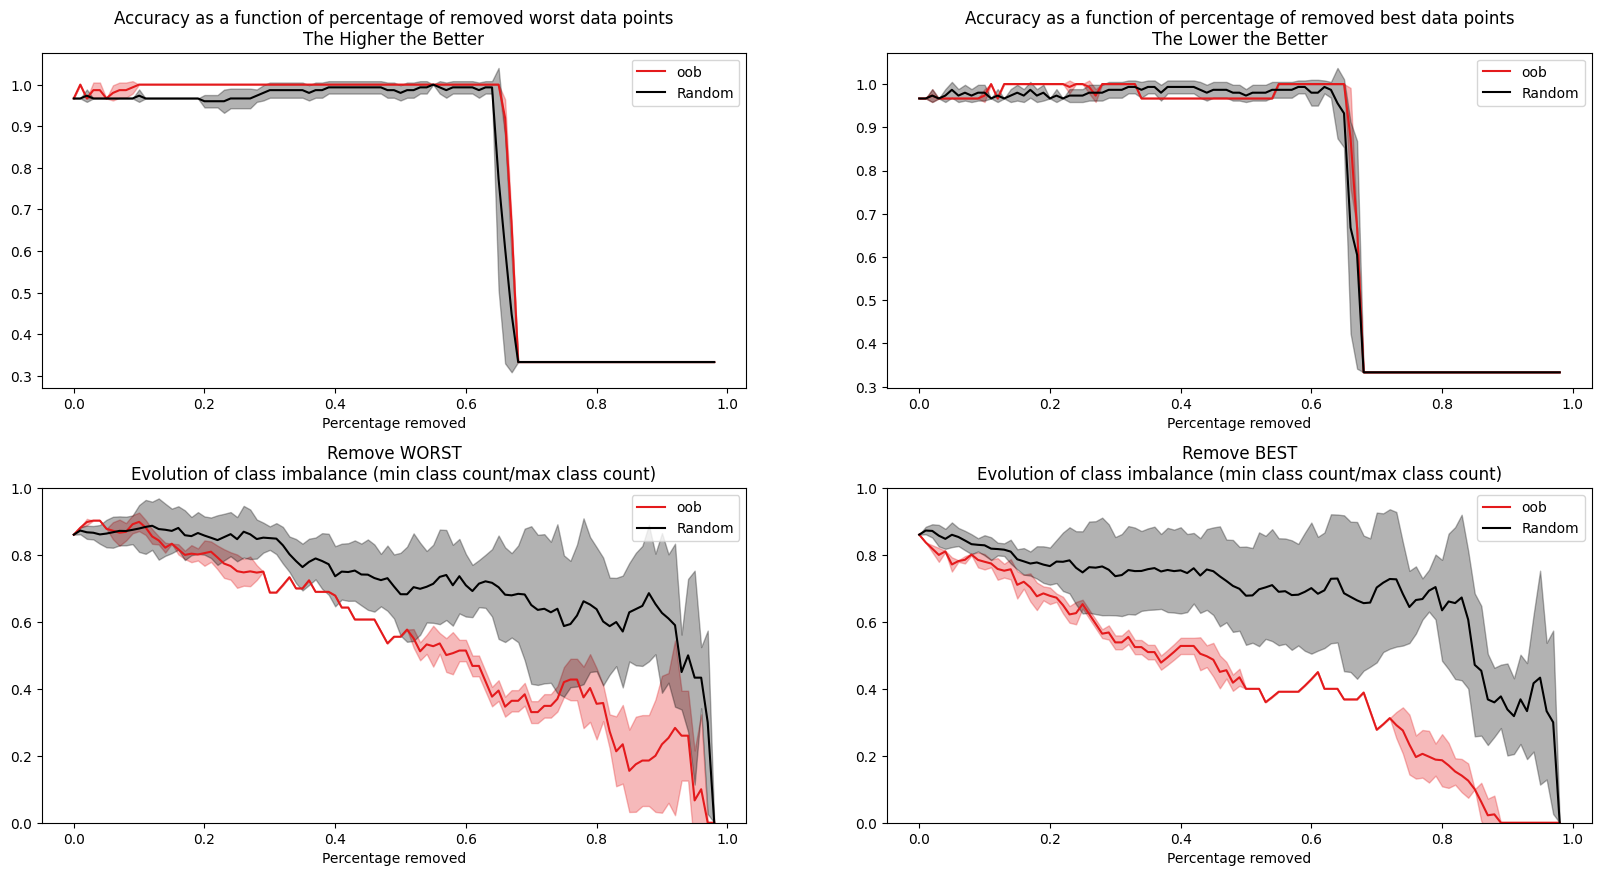

In [19]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="Set1", random_run=True)